In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson
from scipy.stats import norm
import emcee
import pygtc
from scipy.optimize import minimize

# Alberto Pancaldi, Esame TRMD
# Cosmologia con conteggi di Ammassi di Galassie
In questo notebook si vuole analizzare un catalogo di ammassi di galassie, caratterizzati da massa, valore di redshift e volume di universo.

In particolare si vuole studiare la distribuzione delle masse degli ammassi mettendola in paragonare con la distribuzione teoricamente prevista da alcuni parametri cosmologici (Halo Mass Function, HMF).

## Parte 1
Visualizzazione e analisi dei dati.

In [2]:
data = pd.read_csv('Euclid_ammassi.csv')
data = data.drop(columns=data.columns[0])
data

,mass,redshift,volume
0,1.060613e+14,0.506,1.479387e+10
1,1.097076e+14,0.506,1.479387e+10
2,1.588869e+14,0.506,1.479387e+10
3,1.336345e+14,0.506,1.479387e+10
4,3.078288e+14,0.506,1.479387e+10
...,...,...,...
362632,1.002043e+14,1.500,9.112247e+10
362633,1.267961e+14,1.500,9.112247e+10
362634,1.273208e+14,1.500,9.112247e+10
362635,1.093178e+14,1.500,9.112247e+10


In [3]:
data.groupby('redshift').aggregate({'volume': ['min','max'], 'mass': ['count', 'mean', 'min','max']})

volume                  mass                              \
                   min           max   count          mean           min   
redshift                                                                   
0.506     1.479387e+10  1.479387e+10  168897  1.754502e+14  1.000004e+14   
1.019     4.783826e+10  4.783826e+10  142007  1.520161e+14  1.000036e+14   
1.500     9.112247e+10  9.112247e+10   51733  1.370772e+14  1.000017e+14   

                        
                   max  
redshift                
0.506     2.231156e+15  
1.019     1.536768e+15  
1.500     9.605430e+14

In [4]:
data.groupby('redshift')['mass'].describe()

,count,mean,std,min,25%,50%,75%,max
redshift,,,,,,,,
0.506,168897.0,1.754502e+14,1.022009e+14,1.000004e+14,1.162374e+14,1.417421e+14,1.942476e+14,2.231156e+15
1.019,142007.0,1.520161e+14,6.478489e+13,1.000036e+14,1.120814e+14,1.307558e+14,1.668826e+14,1.536768e+15
1.500,51733.0,1.370772e+14,4.304113e+13,1.000017e+14,1.093389e+14,1.230673e+14,1.487753e+14,9.605430e+14


In [5]:
# Definisco il dizionario
bins = {}    

# Faccio variare l'indice i sull'etichetta associata ad ogni bin (0,1,2), faccio variare il valore di redshift sui 3 
# valori individuati in precedenza e chiamo 'gruppo' il data frame associato ad ogni valore di redshift.

for i, (redshift, gruppo) in enumerate(data.groupby('redshift')):
    valore_z = f"z{i + 1}"
    bins[valore_z] = gruppo

In [6]:
bins

{'z1':                 mass  redshift        volume
 0       1.060613e+14     0.506  1.479387e+10
 1       1.097076e+14     0.506  1.479387e+10
 2       1.588869e+14     0.506  1.479387e+10
 3       1.336345e+14     0.506  1.479387e+10
 4       3.078288e+14     0.506  1.479387e+10
 ...              ...       ...           ...
 168892  1.085008e+14     0.506  1.479387e+10
 168893  2.131142e+14     0.506  1.479387e+10
 168894  1.401876e+14     0.506  1.479387e+10
 168895  3.313962e+14     0.506  1.479387e+10
 168896  1.605784e+14     0.506  1.479387e+10
 
 [168897 rows x 3 columns],
 'z2':                 mass  redshift        volume
 168897  1.122773e+14     1.019  4.783826e+10
 168898  1.382684e+14     1.019  4.783826e+10
 168899  2.561905e+14     1.019  4.783826e+10
 168900  1.418248e+14     1.019  4.783826e+10
 168901  1.452855e+14     1.019  4.783826e+10
 ...              ...       ...           ...
 310899  1.195896e+14     1.019  4.783826e+10
 310900  1.005500e+14     1.019  4.783

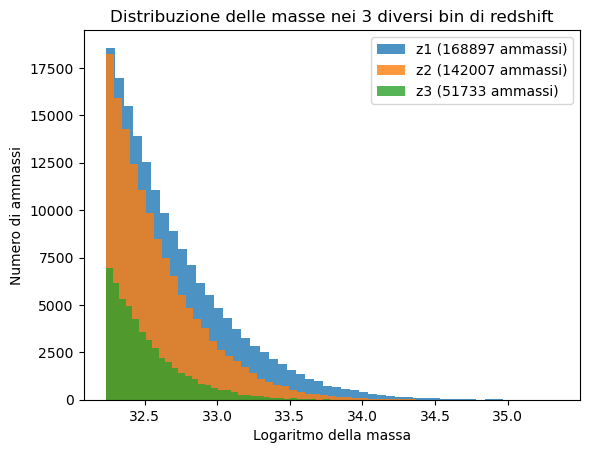

In [7]:
# Faccio variare il valore di redshift e il data frame (gruppo), tra i 3 definiti in precedenza e inseriti in 'bins'.
# Per ciascun valore di z istogrammo i logaritmi dei valori di massa.

for valore_z, gruppo in bins.items():
    conteggio_osservato = len(gruppo)
    plt.hist(np.log(gruppo['mass']), bins=50, alpha=0.8, label=f'{valore_z} ({conteggio_osservato} ammassi)')

plt.xlabel('Logaritmo della massa')
plt.ylabel('Numero di ammassi')
plt.title('Distribuzione delle masse nei 3 diversi bin di redshift')
plt.legend()
plt.show()

## Parte 2: 
Analisi della Halo Mass Function (HMF).

In [8]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

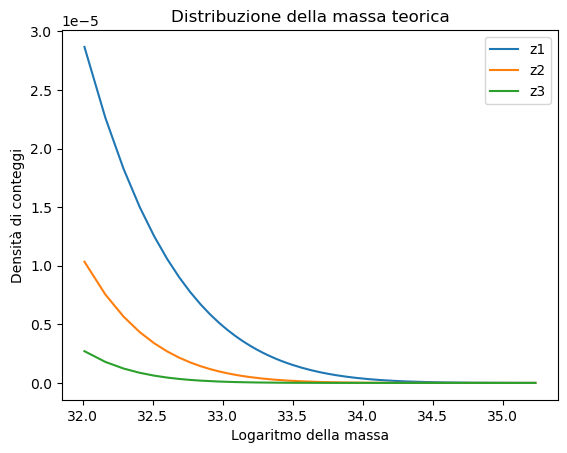

In [9]:
params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.96}

cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

# Introduco un array di valori di masse, in un intervallo tra 10**13 e 10**16
m_arr = np.linspace(8e+13, 2e+15, 150)        

# Faccio variare il valore di redshift, volume di universo e il data frame (gruppo), tra i 3 definiti in precedenza:
for valore_z, gruppo in bins.items():

    z = gruppo['redshift'].max()
    v = gruppo['volume'].max()
    
    # Calcolo la densità dei conteggi della massa per valori fissati di redshift e volume dell'universo.
    mfunc = mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    # N.B. mfunc è la densità di numero per unità di volume normalizzata rispetto all'istogramma dei logaritmi delle masse.
    
    plt.plot(np.log(m_arr), mfunc, label=valore_z)

plt.xlabel('Logaritmo della massa')   
plt.ylabel('Densità di conteggi')   
plt.title('Distribuzione della massa teorica')
plt.legend()
plt.show()


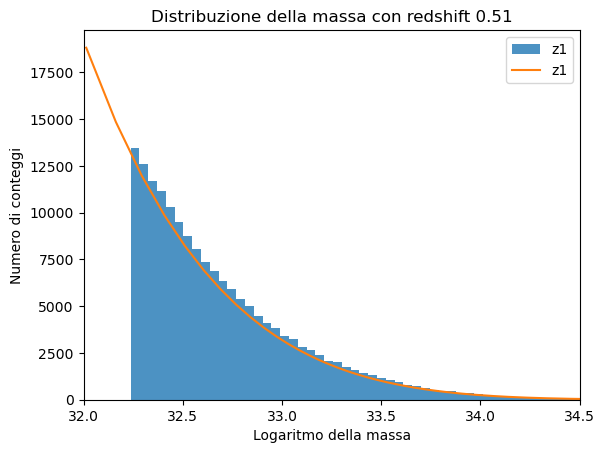

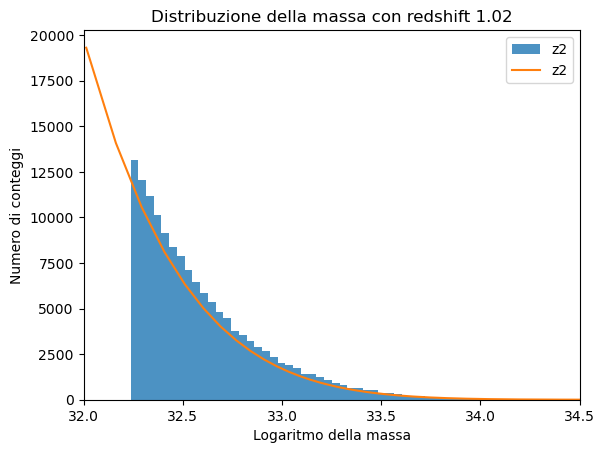

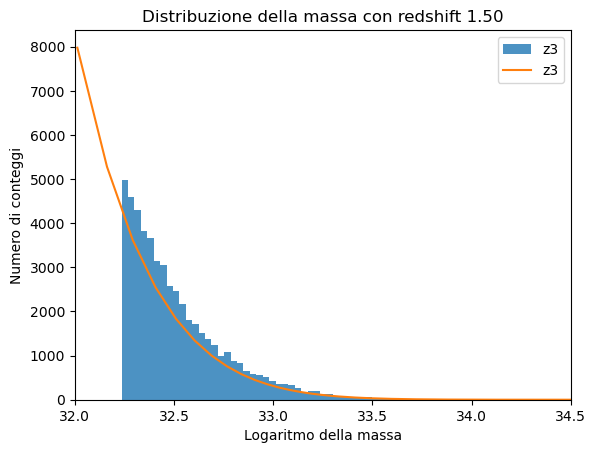

In [10]:
for valore_z, gruppo in bins.items():
    
    plt.hist(np.log(gruppo['mass']), bins=70, alpha=0.8, label=valore_z) 
    width = (np.log(gruppo['mass'].max()) - np.log(gruppo['mass'].min())) / 70
    
    m_arr = np.linspace(8e+13, 2e+15, 150)
    z = gruppo['redshift'].max()
    v = gruppo['volume'].max()
    mfunc = mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    
    # Per ottenere il numero di conteggi teoricamente atteso integro la funzione di densità, quindi semplicemente 
    # moltiplico per la larghezza del bin logaritmico di massa e per il volume di universo.
    num = mfunc * v * width   
    
    plt.plot(np.log(m_arr), num, label=valore_z)
    
    titolo = "Distribuzione della massa con redshift %.2f" % (z)
    plt.title(titolo)
    plt.legend()
    plt.ylabel('Numero di conteggi') 
    plt.xlabel('Logaritmo della massa')  
    plt.xlim(32, 34.5)
    plt.show()

## Parte 3
Inferenza bayesiana sui parametri cosmologici sigma8 e Om0. 

In [11]:
def log_prior(theta):
    sigma8, Om0 = theta
    if 0.1 <= sigma8 <= 1.1 and 0.1 <= Om0 <= 1.1:
        return 0.0
    return -np.inf


    # Fissato il valore di redshift considero il bin associato (gruppo) e istogrammo i logaritmi dei valori di massa.
    # Quindi trovo la larghezza di ogni bin, e il numero di conteggi per bin 'n_obs'.
    # In seguito uso la funzione mass_function per determinare il numero di conteggi teoricamente atteso 'n_exp'.
    
def log_likelihood(theta, gruppo):
    sigma8, Om0 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    counts, bin_edges, _ = plt.hist(np.log(gruppo['mass']), bins=50)
    plt.close()
    width = (np.log(gruppo['mass'].max()) - np.log(gruppo['mass'].min())) / 50
    z = gruppo['redshift'].max()
    v = gruppo['volume'].max()
    m_arr = np.exp(bin_edges)[:-1]  # Escludo l'ultimo elemento per far corrispondere le dimensioni con n_obs
    n_obs = counts    

    # Calcolo il numero teorico atteso di oggetti in ciascun bin di massa per i parametri sigma8 e Om0.
    mfunc = mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    n_exp = mfunc * v * width 
    
    # Sostituisco gli zeri con il valore 1e-100 negli array per evitare divisioni per zero nel calcolo della poissoniana.
    n_exp = np.where(n_exp == 0, 1e-100, n_exp)
    n_obs = np.where(n_obs == 0, 1e-100, n_obs)

    # Calcolo la log-likelihood per ciascun bin di massa, poi le sommo per trovare la log_likelihood totale.
    a= poisson.pmf(n_obs, n_exp)
    a = np.where(a < 1e-100, 1e-100, a)  # Per valori troppo piccoli di a il logaritmo diverge a -inf.
    log_l = np.log(a)
    total_log_likelihood = np.nansum(log_l)
    return total_log_likelihood


def log_posterior(theta, gruppo):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, gruppo)


In [12]:
np.random.seed(41)
nll = lambda *args: -log_posterior(*args)
best_fit = {}

# Inizializzazione casuale dei parametri sigma8 e Om0 a partire dal valore fornito inizialmente.
initial = np.array([0.81, 0.31])

# Faccio variare il valore di redshift e il bin (gruppo) caratterizzato dallo stesso valore di z:
for valore_z, gruppo in bins.items():
    
    # Applico la funzione di minimizzazione alla log-posterior negativa ed estraggo i valori ottimizzati dei parametri.
    args=(gruppo,)
    bounds = [(0.1, 1.1), (0.1, 0.99)]
    soln = minimize(nll, initial, args=args, bounds=bounds)
    sigma8_bf, Om0_bf = soln.x    
    
    best_fit[valore_z] = soln.x    # Dizionario contenente 3 coppie di parametri che massimizzano la log_posterior.

100%|██████████| 1000/1000 [26:10<00:00,  1.57s/it] 


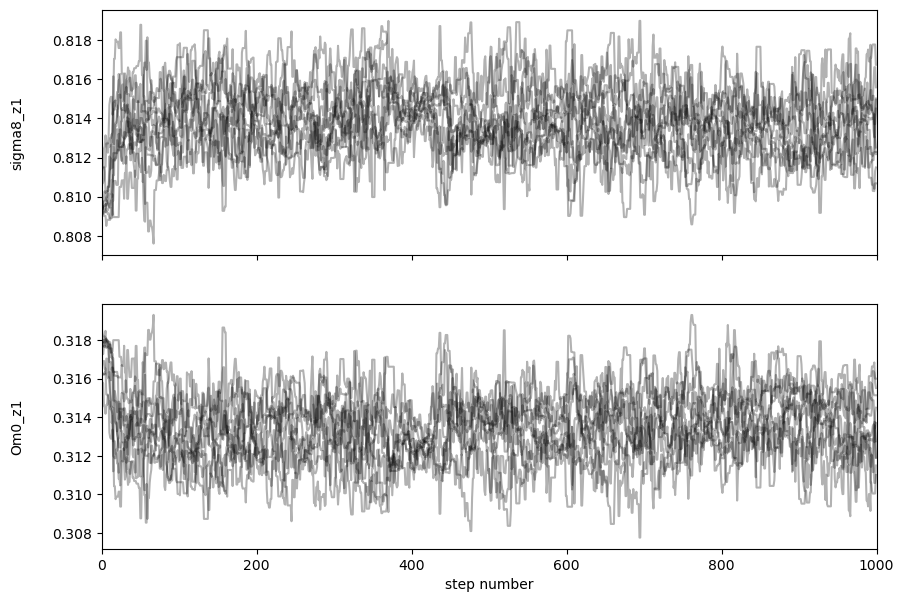

In [13]:
# La tecnica più efficiente per esplorare lo spazio è quella di partire da un intorno dei valori di "best-fit".
# A partire da quel punto i 10 walker andranno a campionare lo spazio (sigma8, Om0) seguendo la posterior distribution.

gruppo = bins['z1']

pos = best_fit['z1'] + 1e-3 * np.random.randn(10, 2)   # Numero di walkers
nwalkers, ndim = pos.shape

# Esecuzione dell'algoritmo EMCEE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)    # Numero di passi

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z1", "Om0_z1"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")


# Ottengo dal sampler la "catena appiattita" ed elimino la fase di burn-in.
flat_samples_1 = sampler.get_chain(discard=100, flat=True)    # falt_samples[passi, walker, parametri]
# Lista di array che contiene i valori della catena, uno per ogni parametro. 


100%|██████████| 1000/1000 [1:09:14<00:00,  4.15s/it]


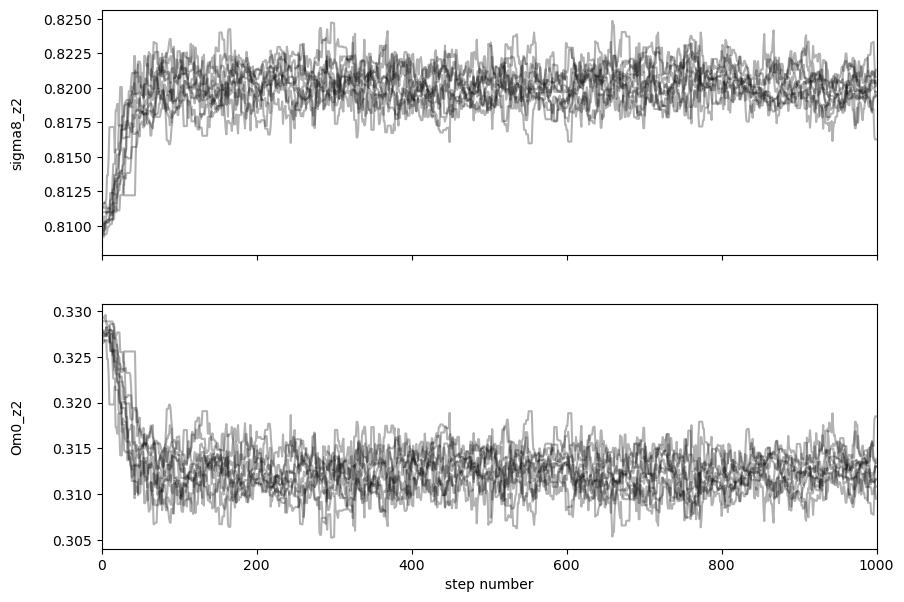

In [14]:
gruppo = bins['z2']

pos = best_fit['z2'] + 1e-3 * np.random.randn(10, 2)   # Numero di walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)    # Numero di passi

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z2", "Om0_z2"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

flat_samples_2 = sampler.get_chain(discard=100, flat=True)


100%|██████████| 1000/1000 [1:11:11<00:00,  4.27s/it]  


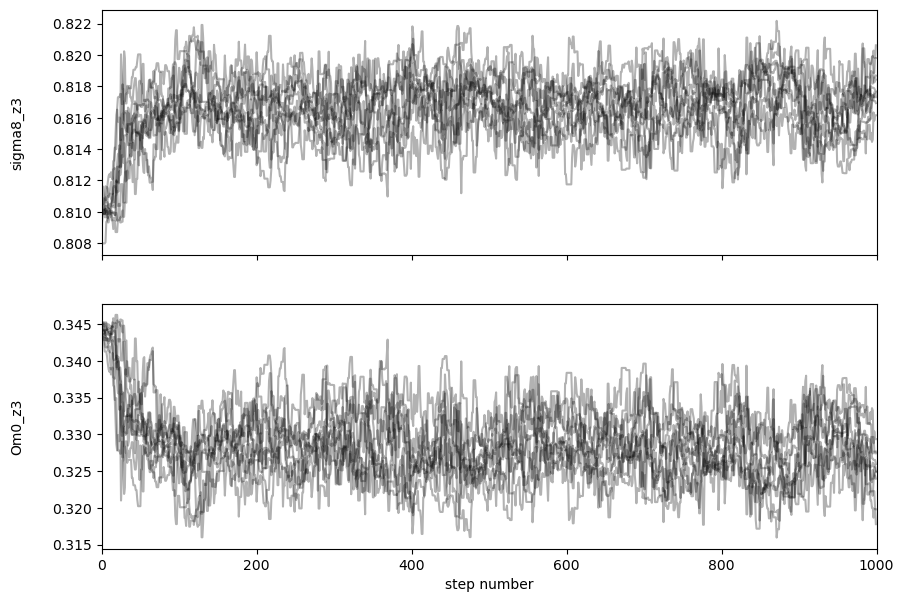

In [15]:
gruppo = bins['z3']

pos = best_fit['z3'] + 1e-3 * np.random.randn(10, 2)   # Numero di walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)    # Numero di passi

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z3", "Om0_z3"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

flat_samples_3 = sampler.get_chain(discard=100, flat=True)


In [17]:
samples = {'z1': flat_samples_1, 'z2': flat_samples_2, 'z3': flat_samples_3}

for valore_z, gruppo in bins.items():
    print(f'Redshift {valore_z}')
    print(f'sigma8 medio: {np.mean(samples[valore_z][:,0])}')
    print(f'Om0 medio: {np.mean(samples[valore_z][:,1])}')
    print()

Redshift z1
sigma8 medio: 0.8138825763074531
Om0 medio: 0.3133846420573744

Redshift z2
sigma8 medio: 0.8202076296792988
Om0 medio: 0.3123632007913453

Redshift z3
sigma8 medio: 0.8167979693885294
Om0 medio: 0.3280994437702792



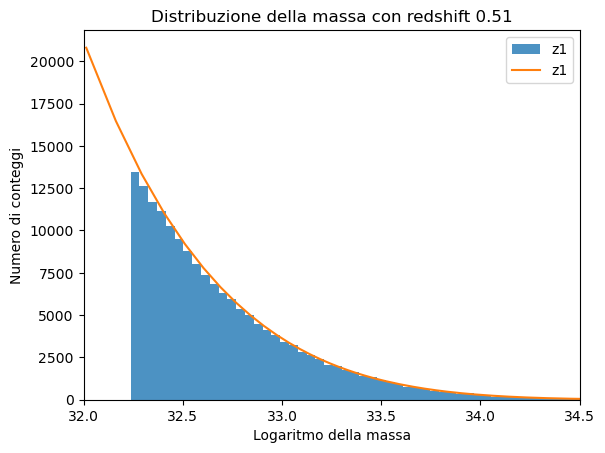

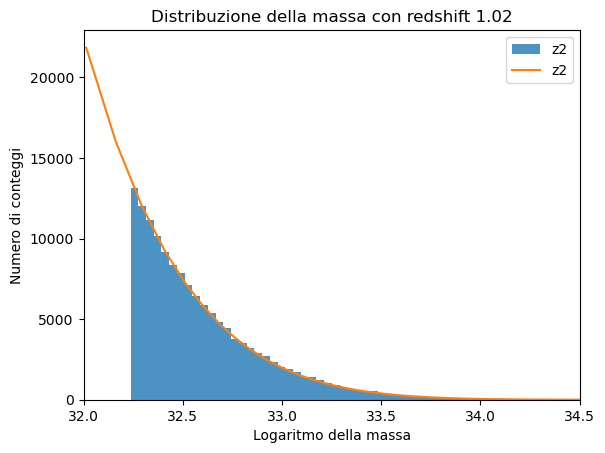

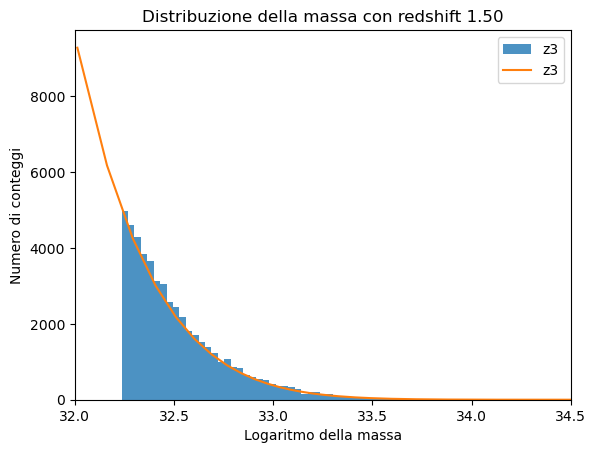

In [18]:
for valore_z, gruppo in bins.items():
    params = {'flat': True, 'H0': 67.77, 'Om0': np.mean(samples[valore_z][:,1]), 'Ob0': 0.049, 'sigma8': np.mean(samples[valore_z][:,0]), 'ns': 0.96}
    
    plt.hist(np.log(gruppo['mass']), bins=70, alpha=0.8, label=valore_z) 
    width = (np.log(gruppo['mass'].max()) - np.log(gruppo['mass'].min())) / 70
    
    m_arr = np.linspace(8e+13, 2e+15, 150)
    z = gruppo['redshift'].max()
    v = gruppo['volume'].max()
    mfunc = mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    
    num = mfunc * v * width   
    plt.plot(np.log(m_arr), num, label=valore_z)
    
    titolo = "Distribuzione della massa con redshift %.2f" % (z)
    plt.title(titolo)
    plt.legend()
    plt.ylabel('Numero di conteggi') 
    plt.xlabel('Logaritmo della massa')  
    plt.xlim(32, 34.5)
    plt.show()

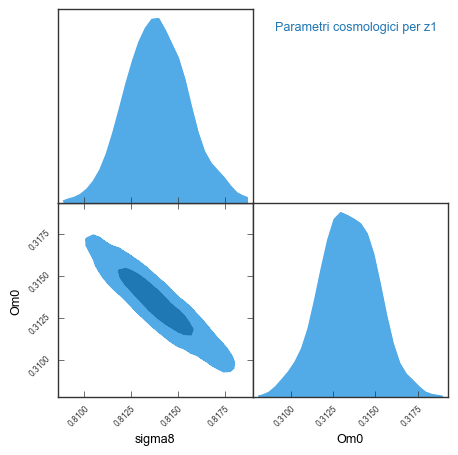

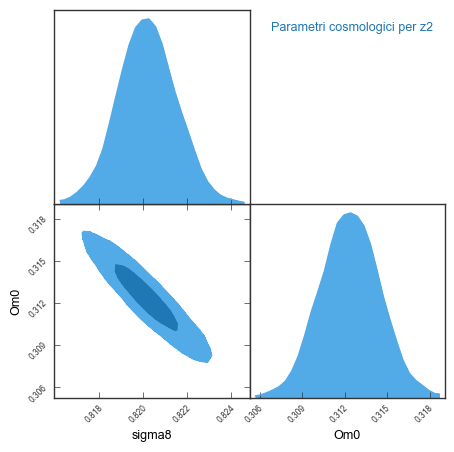

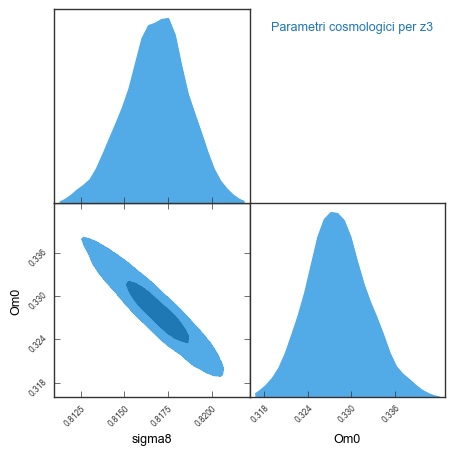

In [19]:
for valore_z, gruppo in bins.items():
    GTC = pygtc.plotGTC(chains=samples[valore_z],
                        paramNames=['sigma8','Om0'],
                        chainLabels=[f'Parametri cosmologici per {valore_z}'],
                        figureSize='MNRAS_page')

## Parte 3 extra
Inferenza bayesiana sui parametri cosmologici sigma8, Om0 e Ode0 e studio della curvatura dell'universo.

In [20]:
def log_prior(theta):
    sigma8, Om0, Ode0 = theta
    if 0.1 <= sigma8 <= 1.1 and 0.1 <= Om0 <= 1.1 and 0.0 <= Ode0 <= 1.1:
        log_prior_Ode0 = norm.logpdf(Ode0, loc=0.7, scale=0.05)
        return log_prior_Ode0
    return -np.inf


def log_likelihood(theta, gruppo):
    sigma8, Om0, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    counts, bin_edges, _ = plt.hist(np.log(gruppo['mass']), bins=50)
    plt.close()
    width = (np.log(gruppo['mass'].max()) - np.log(gruppo['mass'].min())) / 50
    z = gruppo['redshift'].max()
    v = gruppo['volume'].max()
    m_arr = np.exp(bin_edges)[:-1]
    n_obs = counts    

    mfunc = mass_function.massFunction(m_arr, z, mdef='vir', model='despali16', q_out='dndlnM')
    n_exp = mfunc * v * width 
    
    n_exp = np.where(n_exp == 0, 1e-100, n_exp)
    n_obs = np.where(n_obs == 0, 1e-100, n_obs)

    a= poisson.pmf(n_obs, n_exp)
    a = np.where(a < 1e-100, 1e-100, a)
    log_l = np.log(a)
    total_log_likelihood = np.nansum(log_l)
    return total_log_likelihood


def log_posterior(theta, gruppo):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, gruppo)

In [21]:
np.random.seed(41)
nll = lambda *args: -log_posterior(*args)
best_fit = {}

initial = np.array([0.81, 0.31, 0.69])

for valore_z, gruppo in bins.items():
    
    args=(gruppo,)
    bounds = [(0.1, 1.1), (0.1, 0.99), (0.1, 0.99)]
    soln = minimize(nll, initial, args=args, bounds=bounds)
    sigma8_bf, Om0_bf, Ode0_bf = soln.x    
    
    best_fit[valore_z] = soln.x  

100%|██████████| 1000/1000 [47:26<00:00,  2.85s/it]  


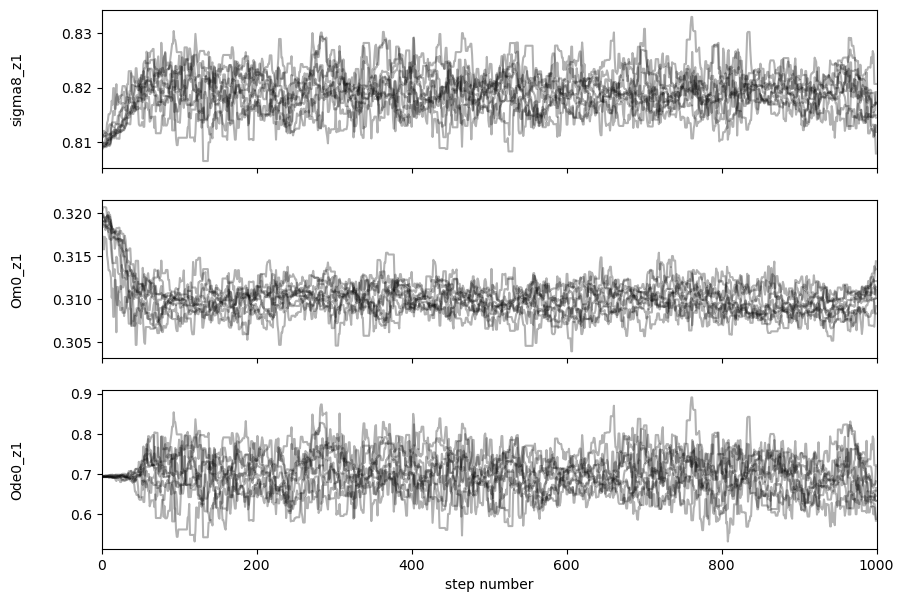

In [22]:
gruppo = bins['z1']

pos = best_fit['z1'] + 1e-3 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z1", "Om0_z1", 'Ode0_z1']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    
flat_samples_4 = sampler.get_chain(discard=100, flat=True)


100%|██████████| 1000/1000 [1:11:44<00:00,  4.30s/it]  


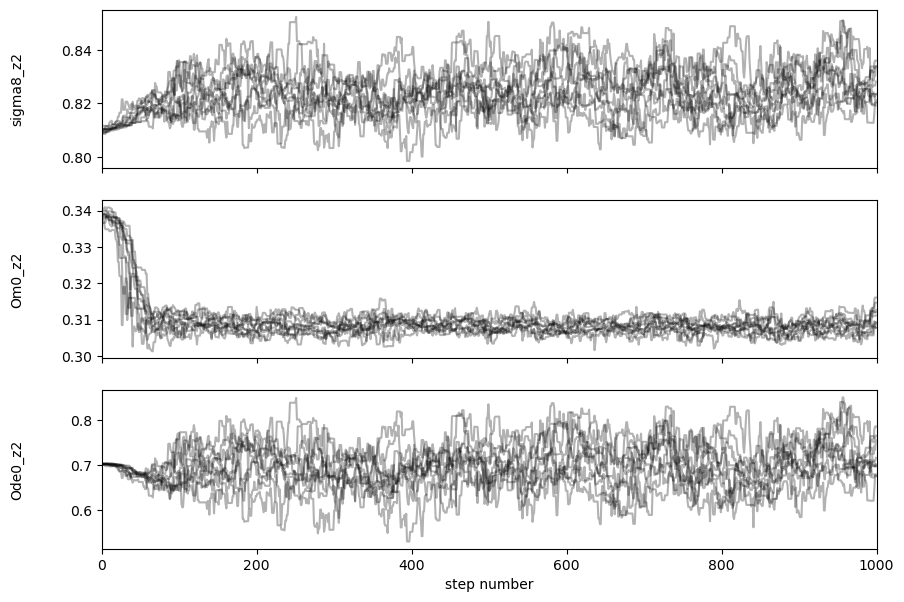

In [23]:
gruppo = bins['z2']

pos = best_fit['z2'] + 1e-3 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z2", "Om0_z2", 'Ode0_z2']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

flat_samples_5 = sampler.get_chain(discard=100, flat=True)


100%|██████████| 1000/1000 [45:17<00:00,  2.72s/it]   


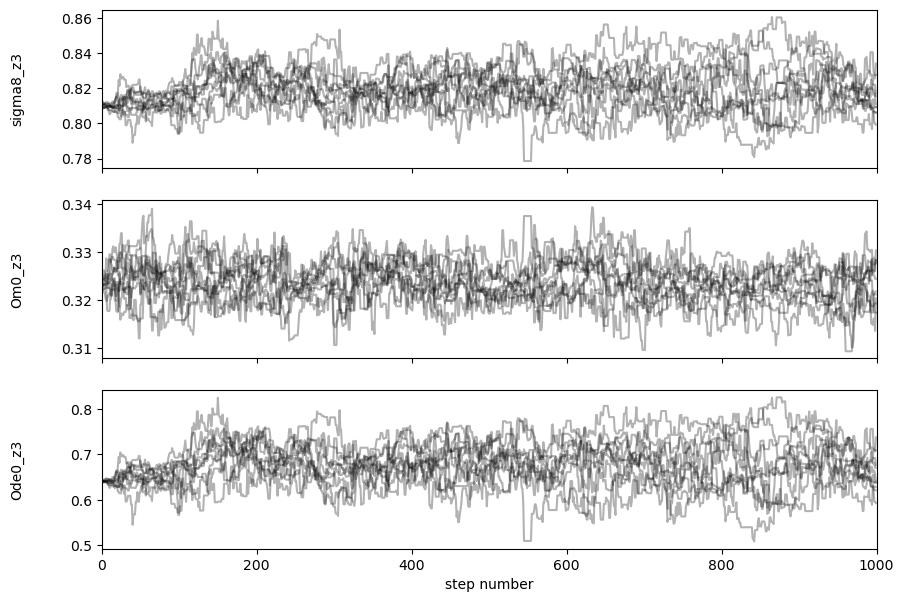

In [24]:
gruppo = bins['z3']

pos = best_fit['z3'] + 1e-3 * np.random.randn(10, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(gruppo,))
sampler.run_mcmc(pos, 1000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z3", "Om0_z3", 'Ode0_z3']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    

flat_samples_6 = sampler.get_chain(discard=100, flat=True)


In [25]:
samples2 = {'z1': flat_samples_4, 'z2': flat_samples_5, 'z3': flat_samples_6}

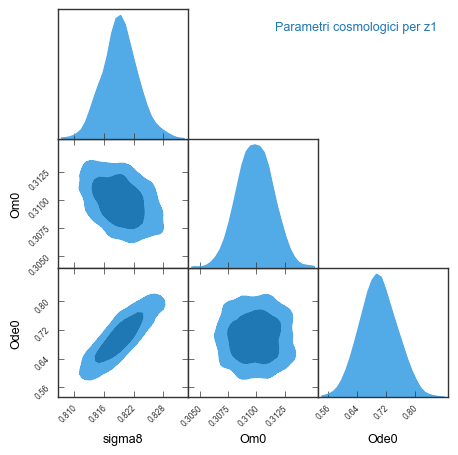

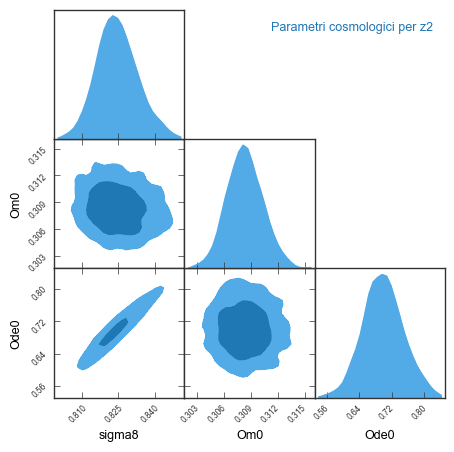

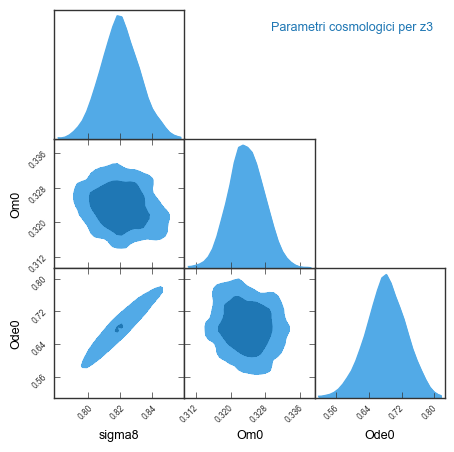

In [26]:
for valore_z, gruppo in bins.items():
    GTC = pygtc.plotGTC(chains=samples2[valore_z],
                        paramNames=['sigma8','Om0','Ode0'],
                        chainLabels=[f'Parametri cosmologici per {valore_z}'],
                        figureSize='MNRAS_page')

In [31]:
for valore_z, gruppo in bins.items():
    print(f'Redshift {valore_z}')
    print(f'sigma8 medio: {np.mean(samples2[valore_z][:,0])}')
    print(f'Om0 medio: {np.mean(samples2[valore_z][:,1])}')
    print(f'Ode0 medio: {np.mean(samples2[valore_z][:,2])}')
    print()

Redshift z1
sigma8 medio: 0.8192304985088862
Om0 medio: 0.30989341591977315
Ode0 medio: 0.6983925828233741

Redshift z2
sigma8 medio: 0.8245132482752061
Om0 medio: 0.30829968104988165
Ode0 medio: 0.698877063285243

Redshift z3
sigma8 medio: 0.8201432249893283
Om0 medio: 0.32360432027399805
Ode0 medio: 0.6810677631755601



Redshift z1
omega_k medio: -0.00828599874314731
dev std omega_k: 0.05008991144668798

Redshift z2
omega_k medio: -0.007176744335124662
dev std omega_k: 0.049363302857145144

Redshift z3
omega_k medio: -0.004672083449558146
dev std omega_k: 0.04781204968364132



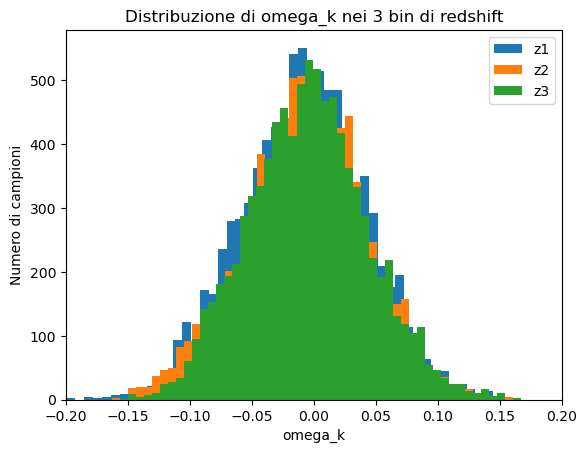

In [36]:
for valore_z, gruppo in bins.items():
    omegak_samples = 1 - samples2[valore_z][:,1] - samples2[valore_z][:,2]
    print(f'Redshift {valore_z}')
    print(f'omega_k medio: {np.mean(omegak_samples)}')
    print(f'dev std omega_k: {np.std(omegak_samples)}')
    print()
    plt.hist(omegak_samples, bins=50, alpha=1, label=valore_z)
    
plt.xlabel('omega_k')
plt.ylabel('Numero di campioni')
plt.title('Distribuzione di omega_k nei 3 bin di redshift')
plt.xlim(-0.2, 0.2)
plt.legend()
plt.show()